In [1203]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

# Creamos dir con las categorias
newpath = './categories' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Folders de train y test
newpath_train = './categories/train'
newpath_test = './categories/test'

def save_file(folder, text):
    with open(folder, 'w') as text_file:
        print(text, file=text_file)

# Obtenemos train
def csv_to_folders(source_file, target_folder):
    with open(source_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        step = 0
        for row in reader:
            cat_folder = target_folder+'/'+row[1]
            target_file = cat_folder+'/'+str(step)+'_'+row[1]+'.txt'
            if not os.path.exists(cat_folder):
                os.makedirs(cat_folder)
                save_file(target_file, row[2])
            else:
                save_file(target_file, row[2])
            step += 1

csv_to_folders('/Users/raulrodriguez_demarque/demarque/market/categories_10000.csv', newpath_train)
csv_to_folders('/Users/raulrodriguez_demarque/demarque/market/categories_1000_test.csv', newpath_test)


In [1204]:
batch_size = 6
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    newpath_train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    shuffle=True,
    seed=seed)

# print(raw_train_ds.unbatch())

Found 10000 files belonging to 1203 classes.
Using 8000 files for training.


In [1207]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [1208]:
print("----------------------- SEPARATOR ----------------------------")
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Text", text_batch.numpy()[i])
    print("Category", label_batch.numpy()[i])
print("----------------------- SEPARATOR ----------------------------")

----------------------- SEPARATOR ----------------------------
Text b'Most of us look at our days in the wrong way: We exaggerate yesterday. We overestimate tomorrow. We underestimate today. The truth is that the most important day you will ever experience is today. Today is the key to your success. Maxwell offers 12 decisions and disciplines - he calls it his daily dozen - that can be learned and mastered by any person to achieve success.\n'
Category [0. 0. 0. ... 0. 0. 0.]
Text b'\n        From the screenwriter of Jurassic Park and War of the Worlds comes the wild and terrifying adventure you\xe2\x80\x99ve been waiting for \xe2\x80\x93 see how it all begins with this FREE EBOOK SAMPLER . . .\n        When Pentagon bioterror operative Roberto Diaz was sent to investigate a suspected biochemical attack, he found something far worse: a highly mutative organism capable of extinction-level destruction.\n        Now, after decades of festering in a forgotten sub-basement, the specimen has 

2024-05-05 07:17:10.328881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1209]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to FBANT000000
Label 1 corresponds to FBANT005000


In [1210]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    newpath_train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    label_mode='categorical', # para CategoricalCrossentropy
    seed=seed)

Found 10000 files belonging to 1203 classes.
Using 2000 files for validation.


In [1240]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    newpath_test,
    batch_size=batch_size,
    #shuffle=True,
    #label_mode='categorical' # CategoricalCrossentropy
)

Found 1020 files belonging to 413 classes.


In [1241]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [1242]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [1243]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
print(">> train_text: "+str(train_text))
vectorize_layer.adapt(train_text)
print(">> vectorize_layer adapted: "+str(vectorize_layer))

>> train_text: <_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
>> vectorize_layer adapted: <TextVectorization name=text_vectorization_36, built=False>


2024-05-05 07:40:37.959092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1244]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [1245]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
print(">> text_batch[0]: "+str(text_batch[0]))
print(">> label_batch[0]: "+str(label_batch[0]))

first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
#print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

>> text_batch[0]: tf.Tensor(b"The wily Texan El Borak, a hardened fighter who stalks the sandscapes of Afghanistan like a vengeful wolf, is rivaled among Howard's creations only by Conan himself. Truly an enduring masterpiece of creative fiction, Tale of El Borak is not to be missed!\n", shape=(), dtype=string)
>> label_batch[0]: tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(1203,), dtype=float32)
Review tf.Tensor(b"The wily Texan El Borak, a hardened fighter who stalks the sandscapes of Afghanistan like a vengeful wolf, is rivaled among Howard's creations only by Conan himself. Truly an enduring masterpiece of creative fiction, Tale of El Borak is not to be missed!\n", shape=(), dtype=string)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2,    1,    1, 4197,    1,    5, 8179, 5379,   30,    1,    2,
           1,    4, 4825,   98,    5,    1, 1427,    9,    1,  265,    1,
        6254,   63,   19,  135,  162,  899,   21, 1361, 3044,    4,  822,
         209

In [1246]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  critic
 313 --->  wrote
Vocabulary size: 10000


In [1247]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [1248]:
# max_acc = 0
# class myCallback(tf.keras.callbacks.Callback): 
#     def on_epoch_end(self, epoch, logs={}): 
#         global max_acc
#         if(logs.get('accuracy') < max_acc):
#             print("\n>> Overfitting at "+str(logs.get('accuracy'))+"!!")   
#             self.model.stop_training = True
#         print(">> ES: "+str(logs.get('accuracy')))
#         max_acc = logs.get('accuracy')

# callbacks = myCallback()

In [1264]:
embedding_dim = 16

# vectorize_layer = tf.keras.layers.TextVectorization(
#     output_mode='int',
#     ngrams=5,
#     output_sequence_length=100)

# vectorize_layer.adapt(X_train)

# basado en https://medium.com/blocksurvey/building-multi-class-text-classifier-using-tensorflow-keras-2148586e69ad
model = tf.keras.Sequential([

    # ESTA COMBINACION FUNCIONA (sin one-hot encoding) 
    tf.keras.layers.Embedding(max_features, embedding_dim, name='embedding'),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(1024, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1203, activation='softmax')

    # original sin errores
    # tf.keras.layers.Dense(64, input_shape=(250,), activation = 'relu'), # NO TOCAR!!!
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dense(1203, activation='softmax')
    
])

model.summary()

# for i, layer in enumerate(model.layers):
#     if i < 2:
#         exit
#     print("-----------------------------------")
#     print(layer.get_config(), layer.get_weights())



Model: "sequential_240"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_47     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [1265]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [1266]:
model.compile(
    # Tiene que ser sparse_categorical si los labels no estan one_hot encoded
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction="sum"),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    # metrics=['accuracy']

    # De otra forma hay que usar CategoricalCrossentropy si son one_hot encoded
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1267]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    # ,
    # callbacks=[callbacks]
)

Epoch 1/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0693 - loss: 5.8556 - val_accuracy: 0.1455 - val_loss: 5.1054
Epoch 2/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1388 - loss: 4.7392 - val_accuracy: 0.1635 - val_loss: 4.8581
Epoch 3/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1648 - loss: 4.3392 - val_accuracy: 0.1740 - val_loss: 4.7260
Epoch 4/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1799 - loss: 4.0126 - val_accuracy: 0.1870 - val_loss: 4.6545
Epoch 5/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2007 - loss: 3.7612 - val_accuracy: 0.1905 - val_loss: 4.5910
Epoch 6/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2096 - loss: 3.5138 - val_accuracy: 0.1850 - val_loss: 4.5963
Epoch 7/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2239 - loss: 3.3291 - val_accuracy: 0.1940 - val_loss: 4.5996
Epoch 8/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2393 - loss: 3.1800 - 

In [ ]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [946]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [947]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: 'accuracy'

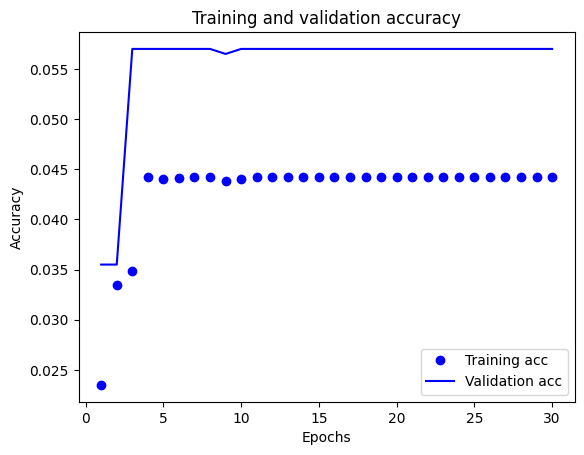

In [803]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [805]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [806]:
predictions = probability_model.predict(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [807]:
predictions[0]

array([0.00083066, 0.00083056, 0.00083067, ..., 0.00083066, 0.00083067,
       0.00083142], dtype=float32)

In [808]:
np.argmax(predictions[0])

762

In [810]:
desc = test_ds.take(1)
desc = (np.expand_dims(desc,0))